In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import sqlite3 as sql
import pandas as pd

In [2]:
DB_FILE = "data/database.sqlite"

In [3]:
db_conn = sql.connect(DB_FILE)

In [4]:
cursor = db_conn.execute("SELECT * FROM Player LIMIT 10")
for row in cursor:
    print(row)

(1, 505942, 'Aaron Appindangoye', 218353, '1992-02-29 00:00:00', 182.88, 187)
(2, 155782, 'Aaron Cresswell', 189615, '1989-12-15 00:00:00', 170.18, 146)
(3, 162549, 'Aaron Doran', 186170, '1991-05-13 00:00:00', 170.18, 163)
(4, 30572, 'Aaron Galindo', 140161, '1982-05-08 00:00:00', 182.88, 198)
(5, 23780, 'Aaron Hughes', 17725, '1979-11-08 00:00:00', 182.88, 154)
(6, 27316, 'Aaron Hunt', 158138, '1986-09-04 00:00:00', 182.88, 161)
(7, 564793, 'Aaron Kuhl', 221280, '1996-01-30 00:00:00', 172.72, 146)
(8, 30895, 'Aaron Lennon', 152747, '1987-04-16 00:00:00', 165.1, 139)
(9, 528212, 'Aaron Lennox', 206592, '1993-02-19 00:00:00', 190.5, 181)
(10, 101042, 'Aaron Meijers', 188621, '1987-10-28 00:00:00', 175.26, 170)


In [5]:
cursor = db_conn.execute("SELECT date FROM Match ORDER BY date LIMIT 10 ")
for row in cursor:
    print(row)

('2008-07-18 00:00:00',)
('2008-07-19 00:00:00',)
('2008-07-20 00:00:00',)
('2008-07-20 00:00:00',)
('2008-07-23 00:00:00',)
('2008-07-23 00:00:00',)
('2008-07-23 00:00:00',)
('2008-07-24 00:00:00',)
('2008-07-24 00:00:00',)
('2008-07-26 00:00:00',)


In [6]:
cursor = db_conn.execute("SELECT * FROM Country")
for row in cursor:
    print(row)

(1, 'Belgium')
(1729, 'England')
(4769, 'France')
(7809, 'Germany')
(10257, 'Italy')
(13274, 'Netherlands')
(15722, 'Poland')
(17642, 'Portugal')
(19694, 'Scotland')
(21518, 'Spain')
(24558, 'Switzerland')


In [7]:
cursor = db_conn.execute("SELECT * FROM League")
for row in cursor:
    print(row)

(1, 1, 'Belgium Jupiler League')
(1729, 1729, 'England Premier League')
(4769, 4769, 'France Ligue 1')
(7809, 7809, 'Germany 1. Bundesliga')
(10257, 10257, 'Italy Serie A')
(13274, 13274, 'Netherlands Eredivisie')
(15722, 15722, 'Poland Ekstraklasa')
(17642, 17642, 'Portugal Liga ZON Sagres')
(19694, 19694, 'Scotland Premier League')
(21518, 21518, 'Spain LIGA BBVA')
(24558, 24558, 'Switzerland Super League')


In [8]:
# classes for data objects
match_columns = "id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal"
betting_sources = ["B365","BW","IW","LB","PS","WH","SJ","VC","GB","BS"]
outcomes = ["H","D","A"]
for b in betting_sources:
    for o in outcomes:
        match_columns += "," + b + o

team_columns = "id,team_api_id,team_fifa_api_id,team_long_name,team_short_name"

def create_lookup(column_names, delim=","):
    return {c: i for (i,c) in enumerate(column_names.split(delim))}

match_column_lookup = create_lookup(match_columns)
team_column_lookup = create_lookup(team_columns)
all_match_ids = []
all_matches = {}
all_teams = {}

class MatchResult:
    HOME = 0
    DRAW = 1
    AWAY = 2
    
    def toStr(mr):
        if mr == MatchResult.HOME:
            return "HOME"
        elif mr == MatchResult.DRAW:
            return "DRAW"
        elif mr == MatchResult.AWAY:
            return "AWAY"
        else:
            return "UNKNOWN RESULT"

def compute_implied_odds(odds):
    return 1./odds

class Match(object):
    def __init__(self, rawData):
        # set attributes
        for col_name in match_column_lookup:
            setattr(self, col_name, rawData[match_column_lookup[col_name]])
            
        self.best_home_odds = self.best_draw_odds = self.best_away_odds = 0
        self.implied_home_odds = self.implied_draw_odds = self.implied_away_odds = 0.
        
        # compute result of match
        if self.home_team_goal > self.away_team_goal:
            self.match_result = MatchResult.HOME
        elif self.home_team_goal == self.away_team_goal:
            self.match_result = MatchResult.DRAW
        else:
            self.match_result = MatchResult.AWAY
            
        # compute best odds across bookmakers and associated implied odds
        odds = {o: [getattr(self, source + o) for source in betting_sources 
                if getattr(self, source + o) is not None] for o in outcomes }
        if len(odds[outcomes[MatchResult.HOME]]) > 0:
            self.best_home_odds = max(odds[outcomes[MatchResult.HOME]])
            self.implied_home_odds = compute_implied_odds(self.best_home_odds)
        if len(odds[outcomes[MatchResult.DRAW]]) > 0:
            self.best_draw_odds = max(odds[outcomes[MatchResult.DRAW]])
            self.implied_draw_odds = compute_implied_odds(self.best_draw_odds)
        if len(odds[outcomes[MatchResult.AWAY]]) > 0:
            self.best_away_odds = max(odds[outcomes[MatchResult.AWAY]])
            self.implied_away_odds = compute_implied_odds(self.best_away_odds)
            
    # input: match, object of class Match
    # output: vector of real-valued features, vector of associated labels
    def compute_features(self, one_hot=False):
        # [home_team_win_percentage,home_team_draw_percentage,home_team_loss_percentage,...
        #  away_team_win_percentage,away_team_draw_percentage,away_team_loss_percentage]
        # TODO: historical matchup percentages
        # TODO: fifa player ratings
        # TODO: fifa team attributes
        # TODO: implied odds?
        home_team = all_teams[self.home_team_api_id]
        away_team = all_teams[self.away_team_api_id]
        features = home_team.features + away_team.features
        features += [self.implied_home_odds, self.implied_draw_odds, self.implied_away_odds]

        if one_hot:
            label = [0 for _ in range(3)]
            label[self.match_result] = 1
            return (features, label)
        else:
            return (features, self.match_result)
    
class Team(object):
    def __init__(self, rawData):
        # set attributes
        for col_name in team_column_lookup:
            setattr(self, col_name, rawData[team_column_lookup[col_name]])        
        self.home_wins = self.home_draws = self.home_losses = 0
        self.away_wins = self.away_draws = self.away_losses = 0       
        self.home_win_percentage = self.home_draw_percentage = self.home_loss_percentage = 0
        self.away_win_percentage = self.away_draw_percentage = self.away_loss_percentage = 0
    
    @property
    def features(self):
        return [self.home_win_percentage, self.away_win_percentage, 
               self.home_draw_percentage, self.away_draw_percentage,
               self.home_loss_percentage, self.away_loss_percentage]

def compute_win_percentages(matches):
    # compute win percentage
    for match in matches.values():
        if match.match_result == MatchResult.HOME:
            all_teams[match.home_team_api_id].home_wins += 1
            all_teams[match.away_team_api_id].away_losses += 1
        elif match.match_result == MatchResult.DRAW:
            all_teams[match.home_team_api_id].home_draws += 1
            all_teams[match.away_team_api_id].away_draws += 1
        else:
            all_teams[match.home_team_api_id].home_losses += 1
            all_teams[match.away_team_api_id].away_wins += 1

    for team in all_teams.values():
        total_home_games = float(team.home_wins + team.home_draws + team.home_losses)
        if total_home_games > 0:
            team.home_win_percentage = team.home_wins / total_home_games
            team.home_draw_percentage = team.home_draws / total_home_games
            team.home_loss_percentage = team.home_losses / total_home_games
        total_away_games = float(team.away_wins + team.away_draws + team.away_losses)
        if total_away_games > 0:
            team.away_win_percentage = team.away_wins / total_away_games
            team.away_draw_percentage = team.away_draws / total_away_games
            team.away_loss_percentage = team.away_losses / total_away_games

In [9]:
# load all matches
# only EPL for now
cursor = db_conn.execute("SELECT %s FROM Match ORDER BY date" % (match_columns))
for row in cursor:
    mid = row[match_column_lookup['match_api_id']]
    all_match_ids.append(mid)
    all_matches[mid] = Match(row)

In [10]:
# load all teams
cursor = db_conn.execute("SELECT %s FROM Team" % (team_columns))
for row in cursor:
    all_teams[row[team_column_lookup['team_api_id']]] = Team(row)

In [11]:
# create training/testing data sets
PROPORTION_TRAIN = 0.9

# filter out matches with no betting data
to_remove = []
for mid in all_matches:
    if all_matches[mid].best_home_odds == 0:
        to_remove.append(mid)
for mid in to_remove:
    all_match_ids.remove(mid)
    del all_matches[mid]

num_matches = len(all_matches)
num_train = int(PROPORTION_TRAIN * num_matches)

training_match_ids = all_match_ids[:num_train]
testing_match_ids = all_match_ids[num_train:]

# only compute statistics using training data
compute_win_percentages({mid:all_matches[mid] for mid in training_match_ids})

Ajax 0.7560975609756098
Manchester United 0.781021897810219
Chelsea 0.708029197080292
SL Benfica 0.8181818181818182
FC Porto 0.8454545454545455
Real Madrid CF 0.8455882352941176
FC Bayern Munich 0.7983870967741935
Celtic 0.7971014492753623
Manchester City 0.7591240875912408
Rangers 0.7368421052631579
FC Barcelona 0.8676470588235294
RSC Anderlecht 0.7422680412371134
PSV 0.7786885245901639


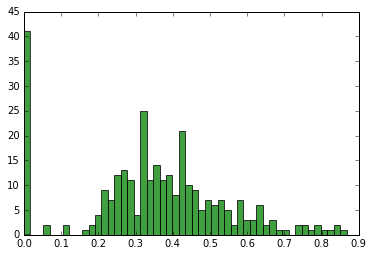

In [12]:
win_percentages = [team.home_win_percentage for team in all_teams.values()]
plt.hist(win_percentages, 50, facecolor='green', alpha=0.75)

for team in all_teams.values():
    if team.home_win_percentage > 0.7:
        print(team.team_long_name, team.home_win_percentage)

In [13]:
class BettingAlgorithm():
    def __init__(self):
        pass
    
    def train(self, matches):
        pass
    
    def form_bets(self, matches):
        pass

def compute_features_from_raw_data(matches, one_hot=False):
    X = []
    y = []
    for match in matches:
        (f,l) = match.compute_features(one_hot=one_hot)
        X.append(f)
        y.append(l)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.uint8)
    return (X, y)

def get_odds(bet):
    if bet[2] == MatchResult.HOME:
        return all_matches[bet[0]].best_home_odds
    elif bet[2] == MatchResult.DRAW:
        return all_matches[bet[0]].best_draw_odds
    else:
        return all_matches[bet[0]].best_away_odds

# bet : (mid, amount, winner)
def calculate_win_loss(b):
    m = all_matches[b[0]]
    odds = get_odds(b)
    if odds == 1.:
        return 0
    elif m.match_result == MatchResult.HOME and b[2] == MatchResult.HOME:
        return b[1] * (odds - 1)
    elif m.match_result == MatchResult.DRAW and b[2] == MatchResult.DRAW:
        return b[1] * (odds - 1)
    elif m.match_result == MatchResult.AWAY and b[2] == MatchResult.AWAY:
        return b[1] * (odds - 1)
    else:
        return -b[1]

def compute_pnl(bets):
    return sum([calculate_win_loss(b) for b in bets])

In [14]:
# naive predictor that always picks favorite
class NaiveAlgorithm(BettingAlgorithm):
    def __init__(self, **kwargs):
        super(NaiveAlgorithm, self).__init__()
    
    def train(self, matches):
        pass
        
    def form_bets(self, matches):
        matches = list(matches)
        bets = []
        for m in matches:
            if m.best_home_odds > 1 and m.best_draw_odds > 1 and m.best_away_odds > 1:
                ind = np.argmin([m.best_home_odds, m.best_draw_odds, m.best_away_odds])
                bets.append((m.match_api_id, 1., ind))
        return bets

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics

# random forest predictor
class RandomForestAlgorithm(BettingAlgorithm):
    def __init__(self, scale_bet=False, **kwargs):
        super(RandomForestAlgorithm, self).__init__()
        self.scale_bet = scale_bet
        self.classifier = RandomForestClassifier(**kwargs)
    
    def train(self, matches):
        X, y = compute_features_from_raw_data(matches)
        self.classifier = self.classifier.fit(X, y)
        
    def form_bets(self, matches):
        matches = list(matches)
        X, y = compute_features_from_raw_data(matches)
        predicted_labels = self.classifier.predict(X)
        print(sum([1 if y_true==y_pred else 0 for (y_true,y_pred) in zip(y,predicted_labels)])/float(len(y)))
        
        # just bet $1 on every thing if not scaled
        bets = []
        for (m,outcome) in zip(matches, predicted_labels):
            probs = [m.implied_home_odds, m.implied_draw_odds, m.implied_away_odds]
            bets.append((m.match_api_id, 1./(1-probs[outcome]) if self.scale_bet else 1., outcome))
        return bets

In [69]:
# neural net algorithm
import tensorflow as tf
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0., shape=shape)
  return tf.Variable(initial)

class BetMaker(object):
    def make_bet(match, probs):
        pass
    
class SureBetter(BetMaker):
    def __init__(self, p_threshold, scale_bet=True):
        self.p_threshold = p_threshold
        self.scale_bet = scale_bet
        
    def make_bet(self, match, probs):
        bets = []
        if max(probs) > self.p_threshold:
            predicted_result = np.argmax(probs)
            bets.append((match.match_api_id, 
                         1./(1-max(probs)) if self.scale_bet else 1., 
                         predicted_result, 
                         probs))
        return bets

class EdgeBetter(BetMaker):
    def __init__(self, scale_bet=True):
        self.scale_bet = scale_bet
        
    def make_bet(self, match, probs):
        bets = []
        try:
            if probs[MatchResult.HOME] > match.implied_home_odds:
                bets.append((match.match_api_id, 1., MatchResult.HOME, probs))
            if probs[MatchResult.DRAW] > match.implied_draw_odds:
                bets.append((match.match_api_id, 1., MatchResult.DRAW, probs))
            if probs[MatchResult.AWAY] > match.implied_away_odds:
                bets.append((match.match_api_id, 1., MatchResult.AWAY, probs))
        except:
            pass
        return bets

class NeuralNetAlgorithm(BettingAlgorithm):
    def __init__(self, bet_maker):
        super(NeuralNetAlgorithm, self).__init__()
        self.num_classes = 3
        self.sess = tf.InteractiveSession()
        self.bet_maker = bet_maker
        self.training_drop_probability = 0.5
    
    def train(self, matches):
        self.X, self.y = compute_features_from_raw_data(matches, one_hot=True)
        self.index_in_epoch = 0
        self.num_examples = self.X.shape[0]
        self.num_features = self.X.shape[1]
        
        # form model
        self.x = tf.placeholder(tf.float32, shape=[None, self.num_features])
        self.y_ = tf.placeholder(tf.float32, shape=[None, self.num_classes])

        # layer 1
        self.hidden_layer_size = 64
        self.W1 = weight_variable([self.num_features, self.hidden_layer_size]) 
        self.b1 = bias_variable([self.hidden_layer_size])
        self.h1 = tf.nn.relu(tf.matmul(self.x, self.W1) + self.b1)
        
        # layer 2
        self.W2 = weight_variable([self.hidden_layer_size, self.num_classes]) 
        self.b2 = bias_variable([self.num_classes]) 
        
        # dropout
        self.keep_prob = tf.placeholder(tf.float32)
        self.y_dropped = tf.nn.dropout(self.h1, self.keep_prob)
        
        # softmax
        self.y_pred = tf.nn.softmax(tf.matmul(self.y_dropped, self.W2) + self.b2)
        
        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.y_ * tf.log(self.y_pred), reduction_indices=[1]))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)

        self.correct_prediction = tf.equal(tf.argmax(self.y_pred,1), tf.argmax(self.y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # actual train
        self.sess.run(tf.initialize_all_variables())
        for i in range(10000):
            batch = self.next_batch(100)
            if i % 1000 == 0:
                train_accuracy = self.accuracy.eval(feed_dict={ self.x: batch[0], self.y_: batch[1], self.keep_prob: 1.0 })
                print("step %d: training accuracy %g" % (i, train_accuracy))
            self.train_step.run(feed_dict={ self.x: batch[0], self.y_: batch[1], 
                                           self.keep_prob: self.training_drop_probability })
    
    def form_bets(self, matches):
        matches = list(matches)
        X, y = compute_features_from_raw_data(matches, one_hot=True)
        acc = self.accuracy.eval(feed_dict={ self.x: X, self.y_: y, self.keep_prob: 1.0 })
        print(acc)
        predictions = self.y_pred.eval(feed_dict={ self.x: X, self.y_: y, self.keep_prob: 1.0 })
        
        # make bet according to bet_maker
        bets = []
        for (m,probs) in zip(matches,predictions):
            bets += self.bet_maker.make_bet(m, probs)
        
        return bets
    
    # serve data by batches
    def next_batch(self, batch_size):
        start = self.index_in_epoch
        self.index_in_epoch += batch_size

        # when all trainig data have been already used, it is reorder randomly    
        if self.index_in_epoch > self.num_examples:
            # shuffle the data
            perm = np.arange(self.num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.y = self.y[perm]
            # start next epoch
            start = 0
            self.index_in_epoch = batch_size
        end = self.index_in_epoch
        return self.X[start:end], self.y[start:end]

In [70]:
# test and evaluate Naive Algo
naive_algo = NaiveAlgorithm()

# train (naive doesn't train)

# evaluate
naive_bets = naive_algo.form_bets([all_matches[mid] for mid in testing_match_ids])
compute_pnl(naive_bets)

-71.0400000000002

In [76]:
# test and evaluate Random Forest Algo
rf_algo = RandomForestAlgorithm(scale_bet=True, n_estimators=50)

# train
rf_algo.train([all_matches[mid] for mid in training_match_ids])

# evaluate
rf_bets = rf_algo.form_bets([all_matches[mid] for mid in testing_match_ids])
compute_pnl(rf_bets)

0.4663716814159292


47.398239825667915

In [77]:
# test and evaluate Neural Net Algo
bet_maker = SureBetter(p_threshold = 0.8, scale_bet = True)
nn_algo = NeuralNetAlgorithm(bet_maker)

# train
nn_algo.train([all_matches[mid] for mid in training_match_ids])

# evaluate
nn_bets = nn_algo.form_bets([all_matches[mid] for mid in testing_match_ids])
compute_pnl(nn_bets)

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fce14140320>>
Traceback (most recent call last):
  File "/home/svatasoiu/anaconda3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 178, in __del__
    self.close()
  File "/home/svatasoiu/anaconda3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1028, in close
    self._default_session.__exit__(None, None, None)
  File "/home/svatasoiu/anaconda3/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/home/svatasoiu/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3529, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


step 0: training accuracy 0.23
step 1000: training accuracy 0.53
step 2000: training accuracy 0.52
step 3000: training accuracy 0.55
step 4000: training accuracy 0.56
step 5000: training accuracy 0.57
step 6000: training accuracy 0.45
step 7000: training accuracy 0.52
step 8000: training accuracy 0.48
step 9000: training accuracy 0.56
0.509292


-10.203307817072162

In [94]:
def examine_bets(bets):
    # (mid, amount, on, probabilities)
    num_bets_won = 0
    for bet in bets:
        match = all_matches[bet[0]]
        bet_odds = get_odds(bet) 
        if match.match_result == bet[2]:
            num_bets_won += 1

        first_arg = " $\033[32m%.4f\033[0m" if match.match_result == bet[2] else "$\033[31m%.4f\033[0m"
        print("%4s: bet $%f on %s @ %f (probs: [%26s], implied: [%.4f,%.4f,%.4f])" % 
              (first_arg % calculate_win_loss(bet),
               bet[1],MatchResult.toStr(bet[2]),bet_odds,
               ",".join(map(str,bet[3] if len(bet) >= 4 else [])),
               match.implied_home_odds,match.implied_draw_odds,match.implied_away_odds))
#         print("%4s BET: bet $%f on %s @ %f (probs: [%26s], implied: [%.4f,%.4f,%.4f])" % 
#               ("WON" if match.match_result == bet[2] else "LOST",
#                bet[1],MatchResult.toStr(bet[2]),bet_odds,
#                ",".join(map(str,bet[3] if len(bet) >= 4 else [])),
#                match.implied_home_odds,match.implied_draw_odds,match.implied_away_odds))
    print("Won %d of %d bets (%f%%)" % (num_bets_won, len(bets), float(num_bets_won)/len(bets)))
    print("PNL: $%f on total wagers of $%f (%f%%)" % 
          (compute_pnl(bets), sum([b[1] for b in bets]), compute_pnl(bets)/sum([b[1] for b in bets])))

In [95]:
examine_bets(rf_bets)

$-1.3521: bet $1.352113 on DRAW @ 3.840000 (probs: [                          ], implied: [0.4545,0.2604,0.2907])
$-2.7544: bet $2.754386 on HOME @ 1.570000 (probs: [                          ], implied: [0.6369,0.2445,0.1429])
 $1.1800: bet $6.555556 on HOME @ 1.180000 (probs: [                          ], implied: [0.8475,0.1297,0.0385])
 $1.3000: bet $4.333333 on HOME @ 1.300000 (probs: [                          ], implied: [0.7692,0.1695,0.0769])
 $1.3300: bet $4.030303 on AWAY @ 1.330000 (probs: [                          ], implied: [0.0833,0.1739,0.7519])
$-2.0417: bet $2.041667 on AWAY @ 1.960000 (probs: [                          ], implied: [0.2208,0.2778,0.5102])
$-1.6667: bet $1.666667 on AWAY @ 2.500000 (probs: [                          ], implied: [0.3096,0.2941,0.4000])
$-1.4367: bet $1.436681 on AWAY @ 3.290000 (probs: [                          ], implied: [0.4167,0.2941,0.3040])
$-1.8333: bet $1.833333 on HOME @ 2.200000 (probs: [                          ], implied

In [96]:
examine_bets(nn_bets)

 $1.0241: bet $5.689593 on HOME @ 1.180000 (probs: [0.824241,0.122894,0.0528656], implied: [0.8475,0.1297,0.0385])
$-5.3134: bet $5.313385 on HOME @ 1.220000 (probs: [0.811796,0.130145,0.0580592], implied: [0.8197,0.1333,0.0667])
 $0.9926: bet $5.838622 on HOME @ 1.170000 (probs: [0.828727,0.117073,0.0542006], implied: [0.8547,0.1016,0.0526])
 $0.6038: bet $6.037904 on HOME @ 1.100000 (probs: [0.83438,0.114352,0.0512683], implied: [0.9091,0.0769,0.0294])
 $0.8080: bet $5.386750 on HOME @ 1.150000 (probs: [0.814359,0.125668,0.0599722], implied: [0.8696,0.0833,0.0323])
 $0.8129: bet $5.806161 on HOME @ 1.140000 (probs: [0.827769,0.119336,0.0528952], implied: [0.8772,0.0909,0.0323])
 $0.8256: bet $7.505231 on HOME @ 1.110000 (probs: [0.86676,0.0967031,0.0365373], implied: [0.9009,0.0769,0.0323])
 $1.2751: bet $5.312931 on HOME @ 1.240000 (probs: [0.81178,0.130966,0.0572536], implied: [0.8065,0.1481,0.0645])
 $1.2066: bet $6.032793 on HOME @ 1.200000 (probs: [0.834239,0.116494,0.0492662], 